In [2]:
%load_ext autoreload
%autoreload 2

# Imports

In [57]:
from fluxes import power_law, cut_off, parabola_index
import matplotlib.cm as cm
import pickle
from os.path import join
from copy import copy
import numpy as np
import pandas as pd
from glob import glob
import warnings
from collections import namedtuple
from itertools import product
import tqdm

from scipy.interpolate import RegularGridInterpolator
from scipy.stats import chi2, norm
from scipy.optimize import fmin_l_bfgs_b
import seaborn as sns
import matplotlib.pyplot as plt

from settings import BASEPATH, ngc1068, txs0506
from tools import get_mids, array_source_interp
from aeff_calculations import get_energy_psf_grid, calc_aeff_factor, get_aeff_and_binnings
from fluxes import (
    atmo_background,
    astro_flux,
)



# Settings

In [4]:
warnings.filterwarnings("ignore")
e_smearing_files = sorted(glob(join(BASEPATH, "resources/*energy_smearing_rgi.pckl")))
sigma5 = 1 - norm.cdf(5)
sigma3 = 1 - norm.cdf(3)
sigma1 = 1 - norm.cdf(1)

# Effective area

We use here only upgoing events with dec>-5deg, since this is the threshold for a pure data set with few muons.

In [5]:
aeff_2d_base, logE_bins_old, _, sindec_bins_old, _ = get_aeff_and_binnings("upgoing")
logE_mids = get_mids(logE_bins_old)
sindec_mids = get_mids(sindec_bins_old)

# provide interpolation function for effective area
aeff_interp = {}
pad_logE = np.concatenate([[logE_bins_old[0]], logE_mids, [logE_bins_old[-1]]])
pad_sd = np.concatenate([[-1], sindec_mids, [1]])
for k in aeff_2d_base:
    aeff_interp[k] = RegularGridInterpolator(
        (pad_logE, pad_sd),
        np.pad(np.log(aeff_2d_base[k]), 1, mode="edge"),
    )

# set up new finer binning
logE_bins = np.linspace(2, 9, num=81)
logE_mids = get_mids(logE_bins)
ebins = np.power(10, logE_bins)
emids = get_mids(ebins)
ewidth = np.diff(ebins)

sindec_bins = np.linspace(-1, 1, num=91)
sindec_mids = get_mids(sindec_bins)
sindec_width = np.diff(sindec_bins)

print(len(emids), "log_10(energy) bins")
print(len(sindec_mids), "declination bins")
# make a baseline evaluation of the interpolation
aeff_2d = {}
ss, ll = np.meshgrid(sindec_mids, logE_mids)
for k in aeff_2d_base:
    aeff_2d[k] = np.exp(aeff_interp[k]((ll, ss)))

80 log_10(energy) bins
90 declination bins


# Background

In [6]:
# MCEQ
with open(join(BASEPATH, "resources/MCEq_flux.pckl"), "rb") as f:
    (e_grid, zen), flux_def = pickle.load(f)
# re-bin the atmospheric background flux
rgi = RegularGridInterpolator(
    (e_grid, -np.cos(np.deg2rad(zen))), np.log(flux_def["numu_conv"])
)
# baseline evaluation
ss, em = np.meshgrid(sindec_mids, emids)
spl_vals = np.exp(rgi((em, ss)))


# Energy resolution function

Plotting code can be found in `energy_resolution.ipynb`

In [7]:
# energy smearing matrix
with open(join(BASEPATH, "resources/energy_smearing_rgi.pckl"), "rb") as f:
    rgi = pickle.load(f)
# new binning
logE_reco_bins = np.arange(1.9, 9.05, step=0.05)
logE_reco_mids = get_mids(logE_reco_bins)
lge_grid, lre_grid = np.meshgrid(logE_mids, logE_reco_mids)
# baseline evaluation
baseline_nkv = rgi((lre_grid, lge_grid))

# normalize per bin in true energy
baseline_nkv = baseline_nkv / np.sum(baseline_nkv, axis=0)

# artificial, improved smearing matrix
with open(
    join(BASEPATH, "resources/improved_0.5_artificial_energy_smearing_rgi.pckl"), "rb"
) as f:
    rgi = pickle.load(f)
improved_nkv = rgi((lre_grid, lge_grid))
# normalize per bin in true energy
improved_nkv = improved_nkv / np.sum(improved_nkv, axis=0)


# PSF-Energy grid from the smearing matrix
$f_x(x) = kde(x)$ with $ x = \log_{10}(y) \Leftrightarrow y = 10^x$

Transform: $z = y² = 10^{(2\cdot x)}$ with $ x = \frac{\log_{10}(z)}{2} := g(z)$

$\Rightarrow f_z(z) = | \frac{d}{dz} g(z) | \cdot f(g(z)) = \frac{1}{2\cdot z \cdot \log(10)} kde(\frac{\log_{10}(z)}{2})$



Full 2D psi-energy LLH of sources around the horizon

NOTE: psi changes per detector over the day. Not yet implemented, effect probably negligible. We choose the horizontal resolution for all detectors

In [8]:
# psi² representation
delta_psi_max = 2
bins_per_psi2 = 25
all_grids, psi2_bins = get_energy_psf_grid(
    logE_mids, delta_psi_max=delta_psi_max, bins_per_psi2=bins_per_psi2
)
psi2_mids = get_mids(psi2_bins)

e_psi2_grid = all_grids['dec-0.0']
bckg_grid = np.ones_like(e_psi2_grid)
bckg_grid /= np.sum(bckg_grid, axis=0)

file exists: /home/lisajsch/repos/Plenum/resources/e_psf_grid_psimax-2_bins-25.pckl


# Flux definition

In [9]:
# we base the flux models on named-tuples
PL_flux = namedtuple("PL_flux", "norm gamma E0 shape")
PLcut_flux = namedtuple("PLcut_flux", "norm gamma e_cut E0 shape")
LogP_flux = namedtuple("LogP_flux", "norm alpha beta E0 shape")

flux_collection = {
    "powerlaw": PL_flux,
    "powerlaw with cutoff": PLcut_flux,
    "log-parabola": LogP_flux,
}

## NGC1068 and TXS 0506+056 - source parameters

In [58]:
# livetime of 10yr PS data
lt_10yr = (376.4 + 352.6 + 316.0 + 332.9 + 2198.2) * 24 * 3600
lt_kde = LIVETIME = 3186 * 24 * 3600
# LIVETIME = 10 * 360 * 24 * 3600 # 360 days of data taking per year

# 10yr PS PAPER PARAMETERS of NGC 1068
GAMMA_NGC = 3.2
PHI_NGC = 5E-14 # @ 1 TeV / GeV cm² s
E0_NGC = 1E3

# ngc flux error contour
gamma_c_68, phi_c_68 = np.loadtxt(join(BASEPATH, "resources/ngc_paper_68_contour.txt"))
phi_c_68 /= 1E11
#gamma_c_68, phi_c_68 = np.loadtxt("../resources/tenyr_paper_68_contour.txt")


# TXS parameters
with open(join(BASEPATH, "resources/txs_contour.pkl"), "rb") as f:
    txs_contour = pickle.load(f)

GAMMA_TXS = 2. #txs_contour["best-fit"][0]
PHI_TXS = 2.7E-20 #txs_contour["best-fit"][1] / 1E3 / 3 # fudge factor. # @ 1 TeV / GeV cm² s
E0_TXS = txs_contour["E0"] 

# parabola parameters
Alpha_TXS = 2
E_para_norm_TXS = 3E5
Beta_TXS = 1

# tmp_flux = LogP_flux(
#     PHI_TXS, Alpha_TXS, Beta_TXS, E_para_norm_TXS, "log-parabola"
# )

ngc_flux = PL_flux(PHI_NGC, GAMMA_NGC, E0_NGC, "powerlaw")
txs_flux = PL_flux(PHI_TXS, GAMMA_TXS, E0_TXS, "powerlaw")


In [59]:
# analysis region in distance to source
delta_psi_max = 2

# generic source config without dec coordinate
src_config = dict(
    sindec_mids=sindec_mids,
    livetime=LIVETIME,
    ewidth=ewidth,
    dpsi_max=0,
    grid_2d=e_psi2_grid,
)
# generic bg config
bg_config = copy(src_config)
bg_config["dpsi_max"] = delta_psi_max
bg_config["grid_2d"] = bckg_grid

# ... with ngc declination
ngc_src_config = copy(src_config)
ngc_src_config["dec"] = ngc1068.dec.rad
ngc_bg_config = copy(bg_config)
ngc_bg_config["dec"] = ngc1068.dec.rad

# ... with txs declination
txs_src_config = copy(src_config)
txs_src_config["dec"] = txs0506.dec.rad
txs_bg_config = copy(bg_config)
txs_bg_config["dec"] = txs0506.dec.rad


## Check event numbers

In [60]:
ident = "Plenum-2" #"IceCube"
aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], **ngc_src_config)
k_s = astro_flux(
    aeff_factor_signal,
    emids,
    normed_kvals=baseline_nkv,
    phi_scaling=1,
    flux_shape=ngc_flux,
)
print("ngc 1068:", np.sum(k_s))  # ~80

## check event numbers
aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], **txs_src_config)
k_s = astro_flux(
    aeff_factor_signal,
    emids,
    normed_kvals=baseline_nkv,
    phi_scaling=1,
    flux_shape=txs_flux,
)
print("txs 0506+056:", np.sum(k_s))  # ~5


ngc 1068: 813.1444924017878
txs 0506+056: 42.34221464953064


# Set up LLH function

In [61]:
def ps_llh_2d_composite(
    x,
    mu_b_base,
    mu_s_base,
    k_i,
    e_0,
    phi_0,
    shape,
    normed_kvals,
    verbose=False,
):
    """fit parameters in x:
    x[0]: background normalization scaling
    x[1]: signal normalization scaling
    x[2:]: other signal parameters
        see 'astro_flux' for further shapes and parameters

    mu_b_base: background baseline
    mu_s_base: effective area factor for signal
    k_i: observation/asimov data
    e_0: normalization energy, default E0_NGC
    phi_0: normalization flux, default PHI_NGC
    shape: flux shape
    """
    mu_b = mu_b_base * x[0]
    mu_s = astro_flux(
        mu_s_base,
        emids,
        normed_kvals,
        x[1],
        flux_collection[shape](
            phi_0, *x[2:], e_0, shape
        ),  # here we generate a flux tuple with the current parameters
    )
    if verbose:
        print(x[0], x[1], *x[2:])
        print(flux_collection[shape](phi_0, *x[2:], e_0, shape))
        print(np.sum(mu_b), np.sum(mu_s))
    mu_i = mu_s + mu_b

    return -2 * np.sum(
        np.where(
            np.logical_and(mu_i > 0, k_i > 0),
            k_i * np.log(mu_i)
            - mu_i
            - 0.5 * np.log(2 * np.pi * k_i)
            + k_i
            - k_i * np.log(k_i),
            0,
        )
    )


# NGC checks

Loop through parameters and check fit results

In [14]:
# cutoff parameters
Gamma_cuts = np.round(np.arange(1.0, 3.1, step=0.2), 2)
logE_cuts = np.round(np.arange(2.5, 4.6, step=0.2), 2)  # log10 (Ecut / GeV)
identifier = "Plenum-2"
# for nkv, es_ident in zip([baseline_nkv, improved_nkv], ["baseline", "improved"]):
nkv = improved_nkv
es_ident = "improved"
pvals_ngc = []

for Gamma_cut, logE_cut in product(Gamma_cuts, logE_cuts):

    # define a temporary baseline flux for first fit iteration
    tmp_flux = PLcut_flux(PHI_NGC, Gamma_cut, logE_cut, E0_NGC, "powerlaw with cutoff")

    aeff_factor_bckg = calc_aeff_factor(aeff_2d[identifier], **ngc_bg_config)
    aeff_factor_signal = calc_aeff_factor(aeff_2d[identifier], **ngc_src_config)

    ### scale the fluxes such that the event numbers match as first iteration
    astro_ev_sum_pl = np.sum(
        astro_flux(
            aeff_factor_signal,
            emids,
            baseline_nkv,
            1,
            ngc_flux,
        )
    )

    # cutoff
    astro_ev_sum_cut = np.sum(
        astro_flux(
            aeff_factor_signal,
            emids,
            baseline_nkv,
            1,
            tmp_flux,
        )
    )
    flux_scaling_cut = astro_ev_sum_pl / astro_ev_sum_cut

    # define the newly normalized PL+cut flux for NGC 1068
    ngc_cut_flux = PLcut_flux(
        PHI_NGC * flux_scaling_cut, Gamma_cut, logE_cut, E0_NGC, "powerlaw with cutoff"
    )

    ## add IceCube to the other detector configs
    if identifier != "IceCube":
        aeff_factor_bckg += calc_aeff_factor(aeff_2d["IceCube"], **ngc_bg_config)
        aeff_factor_signal += calc_aeff_factor(aeff_2d["IceCube"], **ngc_src_config)

    # asimov data
    k_b = atmo_background(
        aeff_factor_bckg,
        array_source_interp(ngc_src_config["dec"], spl_vals, sindec_mids),
        normed_kvals=nkv,
    )
    k_s = astro_flux(
        aeff_factor_signal,
        emids,
        nkv,
        1,
        ngc_cut_flux,  # powerlaw with cutoff
    )

    k_i = k_s + k_b

    dct = dict(
        mu_b_base=k_b,
        mu_s_base=aeff_factor_signal,
        k_i=k_i,
        e_0=ngc_flux.E0,
        normed_kvals=nkv,
    )
    pl_func = lambda x: ps_llh_2d_composite(
        x,
        shape="powerlaw",
        phi_0=ngc_flux.norm,  # normalized with PL baseline flux,
        **dct,
    )
    out_bckg = fmin_l_bfgs_b(
        pl_func,
        x0=(1.0, 1.0, 3.0),
        approx_grad=True,
    )

    comp = lambda x: ps_llh_2d_composite(
        x,
        shape="powerlaw with cutoff",
        phi_0=ngc_cut_flux.norm,  # normalized with PL baseline flux,
        **dct,
    )
    out_comp = fmin_l_bfgs_b(
        comp,
        x0=(1, 1, Gamma_cut, logE_cut),
        approx_grad=True,
    )

    # check the LLH at the "correct" parameter position
    check = comp((1, 1, Gamma_cut, logE_cut))
    pval = chi2.sf(out_bckg[1] - out_comp[1], 1)
    pval_check = chi2.sf(out_bckg[1] - check, 1)
    pvals_ngc.append(
        {
            "identifier": identifier,
            "e_smearing": es_ident,
            "pval": pval,
            "pval_check": pval_check,
            "significance": norm.isf(pval),
            "significance_check": norm.isf(pval_check),
            "gamma_cut": Gamma_cut,
            "logE_cut": logE_cut,
            "flux_scaling": flux_scaling_cut,
            "flux_cut_norm": PHI_NGC * flux_scaling_cut,
            "out_pl_gamma": out_bckg[0][2],
            "out_pl_norm": out_bckg[0][1],
            "out_plc_cut": out_comp[0][3],
            "out_plc_gamma": out_comp[0][2],
            "out_plc_norm": out_comp[0][1],
        }
    )
pvals_ngc = pd.DataFrame(pvals_ngc)
pd.to_pickle(pvals_ngc, join(BASEPATH, f"resources/energy_cut_wiggle_{es_ident}.pckl"))


In [15]:
#pvals_ngc = pd.read_pickle(join(BASEPATH, "resources/energy_cut_wiggle_improved.pckl"))
pvals_ngc["gamma_pl_diff"] = pvals_ngc.out_pl_gamma - GAMMA_NGC
pvals_ngc["norm_pl_diff"] = pvals_ngc.out_pl_norm - 1
pvals_ngc["pcheck_ratio"] = pvals_ngc.pval / pvals_ngc.pval_check

pivot_sigma = pvals_ngc.pivot("logE_cut", "gamma_cut", "significance")
pivot_gamma_diff = pvals_ngc.pivot("logE_cut", "gamma_cut", "gamma_pl_diff")
pivot_norm_diff = pvals_ngc.pivot("logE_cut", "gamma_cut", "norm_pl_diff")

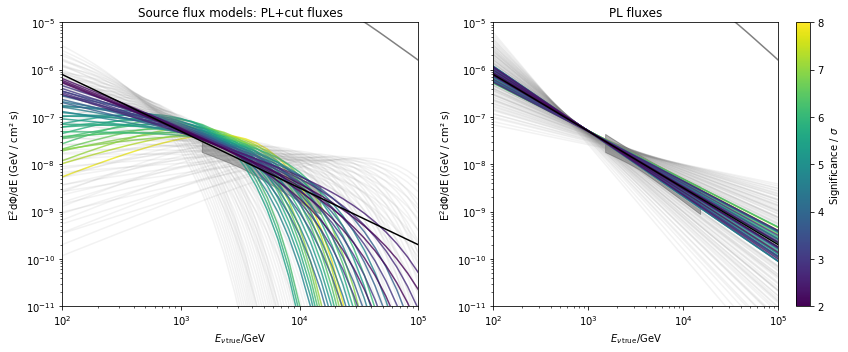

In [62]:
sq_deg = np.pi * delta_psi_max**2
x_evals = np.logspace(0, 9, 100)
y_scaling = 2

f, ax = plt.subplots(ncols=2, figsize=(12, 5))
ax[0].set_title("Source flux models: PL+cut fluxes")
ax[1].set_title("PL fluxes")

cur_cmap = cm.viridis
sigma_min = 2  # np.min(pvals_ngc.significance)
sigma_max = 8  # np.max(pvals_ngc.significance)
color_projection = lambda x: cur_cmap((x - sigma_min) / (sigma_max - sigma_min))
sm = plt.cm.ScalarMappable(
    cmap=cur_cmap, norm=plt.Normalize(vmin=sigma_min, vmax=sigma_max)
)

for (Gamma_cut, logE_cut), series in pvals_ngc.groupby(["gamma_cut", "logE_cut"]):
    # if Gamma_cut != 2: continue
    ## selecting only results that are close to the original fit values
    mask = (np.abs(pivot_gamma_diff) < 0.2) & (np.abs(pivot_norm_diff) < 0.1)
    if mask[Gamma_cut].loc[logE_cut]:
        alpha_val = 0.8
        col = color_projection(series.iloc[0]["significance"])
    else:
        alpha_val = 0.1
        col = "gray"

    # define the correctly normalized PL+cut flux for NGC 1068
    ngc_cut_flux = PLcut_flux(
        PHI_NGC * series.iloc[0]["flux_scaling"],
        Gamma_cut,
        logE_cut,
        E0_NGC,
        "powerlaw with cutoff",
    )
    cut = power_law(
        x_evals, ngc_cut_flux.E0, ngc_cut_flux.gamma, ngc_cut_flux.norm
    ) * cut_off(x_evals, 10**ngc_cut_flux.e_cut)

    ax[0].plot(
        x_evals,
        cut * (x_evals**y_scaling),
        color=col,
        alpha=alpha_val,
    )

    # define the correctly normalized PL flux for NGC 1068
    # using the parameters obtained when fitting the PL+cut flux with PL
    tmp_ngc_flux = PL_flux(
        PHI_NGC * series.iloc[0]["out_pl_norm"],
        series.iloc[0]["out_pl_gamma"],
        E0_NGC,
        "powerlaw",
    )

    pl = power_law(x_evals, tmp_ngc_flux.E0, tmp_ngc_flux.gamma, tmp_ngc_flux.norm)

    ax[1].plot(
        x_evals,
        pl * (x_evals**y_scaling),
        color=col,
        alpha=alpha_val,
    )

# error contour
# with energy range interval
x_cont = np.logspace(np.log10(1.5e3), np.log10(1.5e4), 100)
# without energy range interval
# x_cont = np.logspace(1.9, 5.1, 100)
c_low = np.zeros_like(x_cont)
c_high = np.zeros_like(x_cont)
pl = power_law(x_evals, ngc_flux.E0, ngc_flux.gamma, ngc_flux.norm)

for ii, xe in enumerate(x_cont):
    tmp = power_law(xe, ngc_flux.E0, gamma_c_68, phi_c_68 / 1e3)
    c_low[ii] = np.min(tmp)
    c_high[ii] = np.max(tmp)

cb = plt.colorbar(sm, ax=ax[1])
cb.set_label(r"Significance / $\sigma$")

for axx in ax:
    axx.fill_between(
        x_cont,
        c_low * (x_cont**y_scaling),
        c_high * (x_cont**y_scaling),
        color="k",
        alpha=0.3,
        zorder=1
    )
    axx.plot(
        x_evals,
        pl * (x_evals**y_scaling),
        label=rf"Power law $\gamma=${ngc_flux.gamma}",
        color="k",
        alpha=1,
    )
    axx.plot(
        emids,
        array_source_interp(ngc1068.dec.rad, spl_vals, sindec_mids)
        * sq_deg
        * (emids**y_scaling),
        label="Atmospheric neutrino background",
        color="gray",
    )

    axx.set_yscale("log")
    axx.set_ylabel(r"$\rm E^2 d\Phi / dE$ (GeV / cm² s)")
    axx.set_xscale("log")
    axx.set_xlabel(r"$E_{\nu \, \rm true}$/GeV")
    axx.set_ylim(1e-11, 1e-5)
    axx.set_xlim(1e2, 1e5)
f.tight_layout()


In [56]:
pivot_sigma[(np.abs(pivot_gamma_diff) < 0.2) & (np.abs(pivot_norm_diff) < 0.1)]

gamma_cut,1.0,1.2,1.4,1.6,1.8,2.0,2.2,2.4,2.6,2.8,3.0
logE_cut,,,,,,,,,,,
2.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2.9,6.232752,5.842846,5.432795,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3.1,7.069480,6.648868,6.199178,5.721718,5.219411,4.697059,NaN,NaN,NaN,NaN,NaN
3.3,7.809857,7.368032,6.888799,6.371943,5.819241,5.235116,4.627093,4.005886,NaN,NaN,NaN
3.5,NaN,NaN,NaN,6.922360,6.328302,5.691428,5.019109,4.323508,3.621312,NaN,NaN
3.7,NaN,NaN,NaN,NaN,NaN,6.040656,5.312679,4.551853,3.777603,3.014343,NaN
3.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.674996,3.839746,3.015220,2.232192
4.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.803120,2.931452,2.108915


In [63]:
pivot_gamma_diff[(np.abs(pivot_gamma_diff) < 0.2) & (np.abs(pivot_norm_diff) < 0.1)]

gamma_cut,1.0,1.2,1.4,1.6,1.8,2.0,2.2,2.4,2.6,2.8,3.0
logE_cut,,,,,,,,,,,
2.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2.9,0.095107,0.133315,0.175447,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3.1,-0.049707,-0.013795,0.026040,0.070388,0.119908,0.175254,NaN,NaN,NaN,NaN,NaN
3.3,-0.177847,-0.143430,-0.105086,-0.062153,-0.013877,0.040578,0.101978,0.171282,NaN,NaN,NaN
3.5,NaN,NaN,NaN,-0.180615,-0.132842,-0.078612,-0.016868,0.053444,0.133330,NaN,NaN
3.7,NaN,NaN,NaN,NaN,NaN,-0.185775,-0.123004,-0.050923,0.031691,0.125824,NaN
3.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.144317,-0.058183,0.040682,0.152811
4.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.138032,-0.033723,0.085066


# TXS checks

In [ ]:
# parabola parameters
Alpha_TXS = 2
E_para_norm_TXS = (
    3e5  # that parameter can get absorbed into the others, so this is kept fixed
)
Beta_TXS = 1



In [108]:
# cutoff parameters
alphas = np.round(np.arange(0.8, 3.3, step=0.2), 2)
betas = np.round(np.arange(0.5, 3, step=0.2), 2)  # log10 (Ecut / GeV)
identifier = "Plenum-2"
nkv = improved_nkv
es_ident = "improved"
pvals_txs = []

for alpha, beta in product(alphas, betas):

    # define a temporary baseline flux for first fit iteration
    tmp_flux = LogP_flux(
        PHI_TXS, alpha, beta, E_para_norm_TXS, "log-parabola"
    )

    aeff_factor_bckg = calc_aeff_factor(aeff_2d[identifier], **txs_bg_config)
    aeff_factor_signal = calc_aeff_factor(aeff_2d[identifier], **txs_src_config)

    ### scale the fluxes such that the event numbers match as first iteration
    astro_ev_sum_pl = np.sum(
        astro_flux(
            aeff_factor_signal,
            emids,
            baseline_nkv,
            1,
            txs_flux,
        )
    )

    # log-parabola
    astro_ev_sum = np.sum(
        astro_flux(
            aeff_factor_signal,
            emids,
            baseline_nkv,
            1,
            tmp_flux,
        )
    )
    flux_scaling = astro_ev_sum_pl / astro_ev_sum

    # define the newly normalized log-parabola flux for TXS
    txs_para_flux = LogP_flux(
        PHI_TXS * flux_scaling, alpha, beta, E_para_norm_TXS, "log-parabola"
    )

    ## add IceCube to the other detector configs
    if identifier != "IceCube":
        aeff_factor_bckg += calc_aeff_factor(aeff_2d["IceCube"], **txs_bg_config)
        aeff_factor_signal += calc_aeff_factor(aeff_2d["IceCube"], **txs_src_config)

    # asimov data
    k_b = atmo_background(
        aeff_factor_bckg,
        array_source_interp(txs_src_config["dec"], spl_vals, sindec_mids),
        normed_kvals=nkv,
    )
    k_s = astro_flux(
        aeff_factor_signal,
        emids,
        nkv,
        1,
        txs_para_flux,  # powerlaw with cutoff
    )

    k_i = k_s + k_b

    dct = dict(
        mu_b_base=k_b,
        mu_s_base=aeff_factor_signal,
        k_i=k_i,
        normed_kvals=nkv,
    )
    pl_func = lambda x: ps_llh_2d_composite(
        x,
        shape="powerlaw",
        phi_0=txs_flux.norm,  # normalized with PL baseline flux,
        e_0=txs_flux.E0,
        **dct,
    )
    out_bckg = fmin_l_bfgs_b(
        pl_func,
        x0=(1.0, 1.0, 2.0),
        approx_grad=True,
    )

    comp = lambda x: ps_llh_2d_composite(
        x,
        shape="log-parabola",
        phi_0=txs_para_flux.norm,
        e_0=txs_para_flux.E0,
        **dct,
    )
    out_comp = fmin_l_bfgs_b(
        comp,
        x0=(1, 1, alpha, beta),
        approx_grad=True,
    )

    # check the LLH at the "correct" parameter position
    check = comp((1, 1, alpha, beta))
    pval = chi2.sf(out_bckg[1] - out_comp[1], 1)
    pval_check = chi2.sf(out_bckg[1] - check, 1)
    pvals_txs.append(
        {
            "identifier": identifier,
            "e_smearing": es_ident,
            "pval": pval,
            "pval_check": pval_check,
            "significance": norm.isf(pval),
            "significance_check": norm.isf(pval_check),
            "alpha": alpha,
            "beta": beta,
            "flux_scaling": flux_scaling,
            "flux_para_norm": PHI_TXS * flux_scaling,
            "out_pl_gamma": out_bckg[0][2],
            "out_pl_norm": out_bckg[0][1],
            "out_para_beta": out_comp[0][3],
            "out_para_alpha": out_comp[0][2],
            "out_para_norm": out_comp[0][1],
        }
    )
pvals_txs = pd.DataFrame(pvals_txs)
pd.to_pickle(pvals_txs, join(BASEPATH, f"resources/energy_cut_wiggle_{es_ident}_txs.pckl"))


In [109]:
pvals_txs["gamma_pl_diff"] = pvals_txs.out_pl_gamma - GAMMA_TXS
pvals_txs["norm_pl_diff"] = pvals_txs.out_pl_norm - 1
pvals_txs["pcheck_ratio"] = pvals_txs.pval / pvals_txs.pval_check

pivot_sigma = pvals_txs.pivot("alpha", "beta", "significance")
pivot_gamma_diff = pvals_txs.pivot("alpha", "beta", "gamma_pl_diff")
pivot_norm_diff = pvals_txs.pivot("alpha", "beta", "norm_pl_diff")

In [110]:
pivot_sigma

beta,0.5,0.7,0.9,1.1,1.3,1.5,1.7,1.9,2.1,2.3,2.5,2.7,2.9
alpha,,,,,,,,,,,,,
0.8,1.765995,2.091514,2.296888,2.440688,2.548562,2.633588,2.703022,2.761183,2.810812,2.853758,2.891331,2.924499,2.953990
1.0,1.734724,2.043280,2.245075,2.390067,2.500893,2.589325,2.662065,2.723227,2.775511,2.820790,2.860391,2.895335,2.926407
1.2,1.680515,1.981589,2.184722,2.333736,2.449157,2.541965,2.618608,2.683163,2.738374,2.786175,2.827979,2.864855,2.897626
1.4,1.605355,1.907545,2.116454,2.271949,2.393391,2.491416,2.572509,2.640841,2.699267,2.749825,2.794015,2.832975,2.867581
1.6,1.511719,1.822422,2.040870,2.204916,2.333564,2.437594,2.523665,2.596156,2.658096,2.711652,2.758430,2.799645,2.836234
1.8,1.402693,1.727690,1.958642,2.132904,2.269795,2.380503,2.472041,2.549071,2.614824,2.671628,2.721202,2.764850,2.803574
2.0,1.281927,1.625082,1.870603,2.056320,2.202270,2.320244,2.417704,2.499629,2.569490,2.629785,2.682361,2.728615,2.769626
2.2,1.153391,1.516569,1.777816,1.975782,2.131385,2.257089,2.360843,2.447976,2.522206,2.586214,2.641980,2.691003,2.734439
2.4,1.020930,1.404237,1.681515,1.892081,2.057677,2.191425,2.301754,2.394343,2.473153,2.541060,2.600180,2.652116,2.698101


In [111]:
pivot_gamma_diff

beta,0.5,0.7,0.9,1.1,1.3,1.5,1.7,1.9,2.1,2.3,2.5,2.7,2.9
alpha,,,,,,,,,,,,,
0.8,-0.344708,-0.267083,-0.218522,-0.185118,-0.160722,-0.141875,-0.127016,-0.114919,-0.104911,-0.096487,-0.089139,-0.083300,-0.077794
1.0,-0.283306,-0.219323,-0.179243,-0.151539,-0.131244,-0.115767,-0.103491,-0.093458,-0.085147,-0.078677,-0.072730,-0.067175,-0.062854
1.2,-0.221607,-0.171235,-0.139268,-0.117453,-0.101412,-0.089166,-0.079719,-0.071837,-0.065337,-0.059903,-0.055244,-0.051325,-0.047765
1.4,-0.159366,-0.121991,-0.098695,-0.082860,-0.071681,-0.062588,-0.055453,-0.049854,-0.045207,-0.041373,-0.038109,-0.035258,-0.032760
1.6,-0.095965,-0.072350,-0.057479,-0.047508,-0.040437,-0.035106,-0.030968,-0.027602,-0.024826,-0.022619,-0.020761,-0.019134,-0.017765
1.8,-0.031561,-0.021133,-0.015379,-0.011923,-0.009576,-0.007788,-0.006391,-0.005286,-0.004372,-0.003647,-0.003098,-0.002687,-0.002267
2.0,0.035010,0.031206,0.027893,0.025041,0.022801,0.020829,0.019180,0.017819,0.016682,0.015797,0.014886,0.013867,0.013197
2.2,0.103107,0.084828,0.071865,0.062599,0.055342,0.049592,0.044957,0.041072,0.037966,0.035218,0.032891,0.030851,0.029077
2.4,0.173101,0.139980,0.117363,0.100816,0.088476,0.078942,0.070934,0.064335,0.059494,0.055033,0.051217,0.047890,0.044891


In [112]:
pivot_norm_diff

beta,0.5,0.7,0.9,1.1,1.3,1.5,1.7,1.9,2.1,2.3,2.5,2.7,2.9
alpha,,,,,,,,,,,,,
0.8,0.007252,0.192688,0.300715,0.368900,0.415195,0.448764,0.473462,0.492587,0.507613,0.519655,0.530408,0.538561,0.545435
1.0,0.141103,0.285267,0.368117,0.420371,0.456116,0.481524,0.500634,0.515616,0.527756,0.537956,0.545311,0.551500,0.557112
1.2,0.258623,0.363036,0.424507,0.462918,0.489505,0.508667,0.523458,0.534594,0.543729,0.551009,0.557294,0.562431,0.566882
1.4,0.351759,0.425052,0.467789,0.495256,0.515904,0.529354,0.540314,0.548940,0.555909,0.561846,0.566676,0.570905,0.574587
1.6,0.414422,0.465273,0.495805,0.516847,0.531860,0.543055,0.551624,0.558763,0.564705,0.569315,0.573349,0.577177,0.580050
1.8,0.440291,0.482043,0.508742,0.526147,0.539615,0.549648,0.557425,0.563765,0.568847,0.573255,0.576969,0.580795,0.583085
2.0,0.427509,0.473462,0.502789,0.522898,0.537313,0.548344,0.557279,0.563594,0.569126,0.573852,0.577636,0.581143,0.584381
2.2,0.375303,0.439936,0.479851,0.506350,0.525306,0.539052,0.550174,0.558324,0.564861,0.570268,0.574832,0.578638,0.581938
2.4,0.286962,0.381586,0.438107,0.477149,0.503294,0.522154,0.536602,0.547558,0.555980,0.563130,0.569019,0.574305,0.578328


In [120]:
from tools import ang_dist

In [132]:
exp_data = []
for fn in glob("/data/plenum/icecube_10year_ps/events/*.csv"):
    ident = fn.split("/")[-1].split("_exp")[0]
    exp_data.extend(np.genfromtxt(fn, names=True))
exp_data = np.array(exp_data)


In [ ]:

angular_distances = np.rad2deg(
    ang_dist(
        txs0506.ra.rad,
        txs0506.dec.rad,
        np.deg2rad(exp_data["RAdeg"]),
        np.deg2rad(exp_data["Decdeg"]),
    )
)[0]

selection = exp_data[angular_distances <= 3 * exp_data['AngErrdeg']]
angular_distances = angular_distances[angular_distances <= 3 * exp_data['AngErrdeg']]

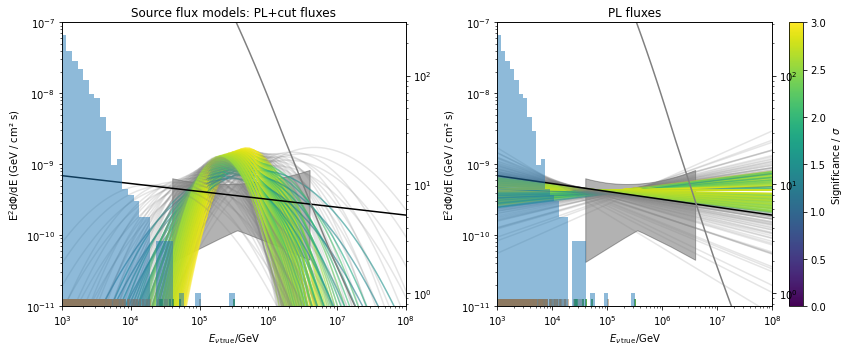

In [146]:
sq_deg = np.pi * delta_psi_max**2
x_evals = np.logspace(3, 9, 100)
y_scaling = 2

f, ax = plt.subplots(ncols=2, figsize=(12, 5))
ax[0].set_title("Source flux models: PL+cut fluxes")
ax[1].set_title("PL fluxes")

cur_cmap = cm.viridis
sigma_min = 0
sigma_max = 3
color_projection = lambda x: cur_cmap((x - sigma_min) / (sigma_max - sigma_min))
sm = plt.cm.ScalarMappable(
    cmap=cur_cmap, norm=plt.Normalize(vmin=sigma_min, vmax=sigma_max)
)

for (alpha, beta), series in pvals_txs.groupby(["alpha", "beta"]):
    # if Gamma_cut != 2: continue
    ## selecting only results that are close to the original fit values
    # mask = (np.abs(pivot_gamma_diff) < 0.2) & (np.abs(pivot_norm_diff) < 0.1)
    mask = np.abs(pivot_gamma_diff) < 0.1
    if mask[beta].loc[alpha]:
        alpha_val = 0.6
        col = color_projection(series.iloc[0]["significance"])
    else:
        alpha_val = 0.2
        col = "gray"

    # define the correctly normalized log-parabola for TXS
    logp = power_law(
        x_evals,
        E_para_norm_TXS,
        parabola_index(alpha, beta, x_evals, E_para_norm_TXS),
        series.iloc[0]["flux_para_norm"],
    )

    ax[0].plot(
        x_evals,
        logp * (x_evals**y_scaling),
        color=col,
        alpha=alpha_val,
    )

    # define the correctly normalized PL flux for TXS
    # using the parameters obtained when fitting the log-P flux with PL
    pl = power_law(
        x_evals,
        E0_TXS,
        series.iloc[0]["out_pl_gamma"],
        PHI_TXS * series.iloc[0]["out_pl_norm"],
    )

    ax[1].plot(
        x_evals,
        pl * (x_evals**y_scaling),
        color=col,
        alpha=alpha_val,
    )

# error contour
x_cont = np.logspace(np.log10(4e4), np.log10(4e6), 100)
c_low = np.zeros_like(x_cont)
c_high = np.zeros_like(x_cont)
for ii, xe in enumerate(x_cont):
    tmp = power_law(
        xe,
        txs_flux.E0,
        txs_contour["68\\%"][:, 0],
        txs_contour["68\\%"][:, 1] / 1e3 / 2.8,
    )  ## fudge factor :)
    c_low[ii] = np.min(tmp)
    c_high[ii] = np.max(tmp)

cb = plt.colorbar(sm, ax=ax[1])
cb.set_label(r"Significance / $\sigma$")

for axx in ax:
    axx.fill_between(
        x_cont,
        c_low * (x_cont**y_scaling),
        c_high * (x_cont**y_scaling),
        color="k",
        alpha=0.3,
        zorder=1,
    )
    axx.plot(
        x_evals,
        pl * (x_evals**y_scaling),
        label=rf"Power law $\gamma=${txs_flux.gamma}",
        color="k",
        alpha=1,
    )
    axx.plot(
        emids,
        array_source_interp(txs0506.dec.rad, spl_vals, sindec_mids)
        * sq_deg
        * (emids**y_scaling),
        label="Atmospheric neutrino background",
        color="gray",
    )
    ax2 = axx.twinx()
    ax2.hist(10 ** selection["log10EGeV"], bins=np.logspace(2, 6), alpha=0.5, zorder=1)
    ax2.set_yscale("log")

    sns.rugplot(x=10 ** selection["log10EGeV"], ax=axx, alpha=0.3, lw=2)
    sns.rugplot(x=10 ** selection["log10EGeV"], ax=axx, alpha=0.3, lw=2)
    sns.rugplot(
        x=10
        ** selection["log10EGeV"][
            (selection["log10EGeV"] > 4.3)
            & (selection["AngErrdeg"] <= 5)
            & (angular_distances <= 2 * selection["AngErrdeg"])
        ],
        ax=axx,
        alpha=0.7,
        lw=2,
    )
    axx.set_yscale("log")
    axx.set_ylabel(r"$\rm E^2 d\Phi / dE$ (GeV / cm² s)")
    axx.set_xscale("log")
    axx.set_xlabel(r"$E_{\nu \, \rm true}$/GeV")
    axx.set_ylim(1e-11, 1e-7)
    axx.set_xlim(1e3, 1e8)
f.tight_layout()


In [114]:
pivot_sigma[np.abs(pivot_gamma_diff) < 0.1]

beta,0.5,0.7,0.9,1.1,1.3,1.5,1.7,1.9,2.1,2.3,2.5,2.7,2.9
alpha,,,,,,,,,,,,,
0.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.853758,2.891331,2.924499,2.953990
1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.723227,2.775511,2.820790,2.860391,2.895335,2.926407
1.2,NaN,NaN,NaN,NaN,NaN,2.541965,2.618608,2.683163,2.738374,2.786175,2.827979,2.864855,2.897626
1.4,NaN,NaN,2.116454,2.271949,2.393391,2.491416,2.572509,2.640841,2.699267,2.749825,2.794015,2.832975,2.867581
1.6,1.511719,1.822422,2.040870,2.204916,2.333564,2.437594,2.523665,2.596156,2.658096,2.711652,2.758430,2.799645,2.836234
1.8,1.402693,1.727690,1.958642,2.132904,2.269795,2.380503,2.472041,2.549071,2.614824,2.671628,2.721202,2.764850,2.803574
2.0,1.281927,1.625082,1.870603,2.056320,2.202270,2.320244,2.417704,2.499629,2.569490,2.629785,2.682361,2.728615,2.769626
2.2,NaN,1.516569,1.777816,1.975782,2.131385,2.257089,2.360843,2.447976,2.522206,2.586214,2.641980,2.691003,2.734439
2.4,NaN,NaN,NaN,NaN,2.057677,2.191425,2.301754,2.394343,2.473153,2.541060,2.600180,2.652116,2.698101


Text(0.5, 0, 'alpha')

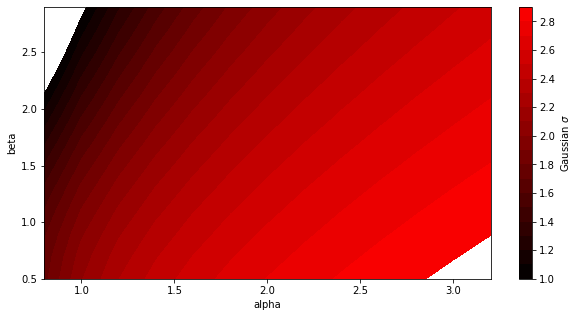

In [119]:
plt.figure(figsize=(10, 5))
plt.contourf(
    pivot_sigma.index.values,
    pivot_sigma.columns.values,
    pivot_sigma,
    levels=np.arange(1, 3, step=0.1),
    cmap=sns.blend_palette(["black", "red"], as_cmap=True),
)
cb = plt.colorbar()
cb.set_label(r"Gaussian $\sigma$")
plt.ylabel("beta")
plt.xlabel("alpha")

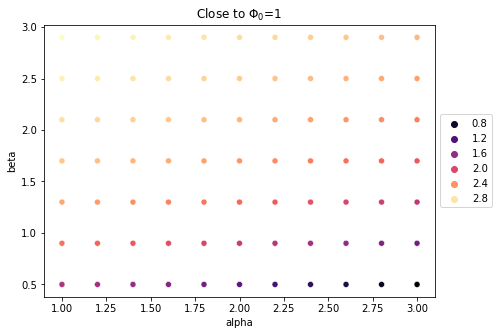

In [97]:
plt.figure(figsize=(7, 5))
ax = sns.scatterplot(
    data=pvals_txs, x="alpha", y="beta", hue="significance", palette="magma"
)
ax.set_title(rf"Close to $\Phi_0$=1")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))


# stuff

Text(0, 0.5, '$\\gamma$')

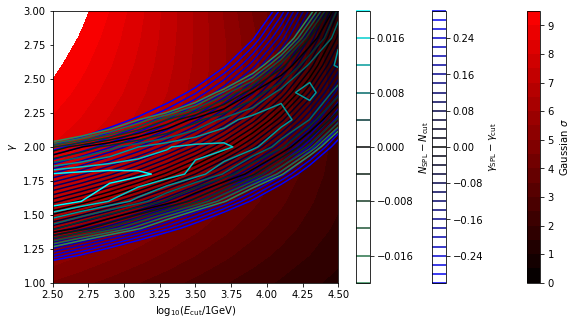

In [19]:
plt.figure(figsize=(10, 5))
plt.contourf(
    pivot_sigma.index.values,
    pivot_sigma.columns.values,
    pivot_sigma,
    levels=np.arange(10, step=0.5),
    cmap=sns.blend_palette(["black", "red"], as_cmap=True),
)
cb = plt.colorbar()
cb.set_label(r"Gaussian $\sigma$")

# gamma difference
plt.contour(
    pivot_gamma_diff.index.values,
    pivot_gamma_diff.columns.values,
    pivot_gamma_diff,
    cmap=sns.blend_palette(["blue", "black", "blue"], as_cmap=True), levels=np.linspace(-0.3, 0.3, 31)
)
cb = plt.colorbar()
cb.set_label(r"$\gamma_{\rm SPL} - \gamma_{\rm cut}$")

# norm difference
plt.contour(
    pivot_norm_diff.index.values,
    pivot_norm_diff.columns.values,
    pivot_norm_diff,
    cmap=sns.blend_palette(["seagreen", "black", "cyan"], as_cmap=True), levels=np.linspace(-0.02, 0.02, 11)
)
cb = plt.colorbar()
cb.set_label(r"$N_{\rm SPL} - N_{\rm cut}$")

plt.xlabel(r"$\log_{10}(E_{\rm cut} / 1 {\rm GeV})$")
plt.ylabel(r"$\gamma$")


In [55]:
pivot_norm_diff[np.abs(pivot_norm_diff) < 0.1] #np.abs(pivot_gamma_diff) < 0.1]

gamma_cut,1.0,1.2,1.4,1.6,1.8,2.0,2.2,2.4,2.6,2.8,3.0
logE_cut,,,,,,,,,,,
2.5,-0.099163,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2.7,-0.032080,-0.043040,-0.056133,-0.072304,-0.092151,NaN,NaN,NaN,NaN,NaN,NaN
2.9,0.005250,-0.001324,-0.009168,-0.018872,-0.031204,-0.046793,-0.067025,-0.093004,NaN,NaN,NaN
3.1,0.023201,0.020035,0.015837,0.010364,0.003207,-0.006223,-0.018932,-0.036393,-0.060250,-0.092471,NaN
3.3,0.020425,0.021855,0.022119,0.021125,0.018667,0.014387,0.007641,-0.002715,-0.018460,-0.041996,-0.075771
3.5,-0.008668,-0.000372,0.006315,0.011951,0.015679,0.017519,0.017092,0.013549,0.005366,-0.009817,-0.035418
3.7,-0.066904,-0.049991,-0.034328,-0.020222,-0.008000,0.002130,0.009762,0.014318,0.014511,0.007923,-0.009011
3.9,NaN,NaN,NaN,-0.076179,-0.053411,-0.032751,-0.014753,0.000031,0.010293,0.013681,0.006215
4.1,NaN,NaN,NaN,NaN,NaN,-0.086078,-0.055690,-0.028707,-0.006060,0.009129,0.012479


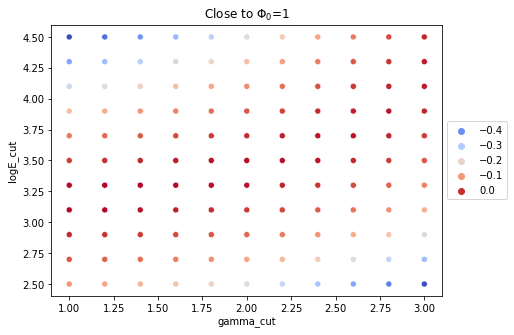

In [21]:
plt.figure(figsize=(7, 5))
ax = sns.scatterplot(data=pvals_ngc, x="gamma_cut", y="logE_cut", hue="norm_pl_diff", palette="coolwarm")
ax.set_title(fr"Close to $\Phi_0$=1")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))